[__DDPG Phil Tabor__](https://github.com/philtabor/Actor-Critic-Methods-Paper-To-Code/blob/master/DDPG/ddpg_torch.py)<br>
[__DDPG Maths__](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)

In [22]:
import torch as T
from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.distributions import Categorical
import math

import ddpg
import gymnasium as gym
import os, random
from pathlib import Path
from collections import deque

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from IPython.display import clear_output

In [23]:
env_id = 'Pendulum-v1'
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.shape[0]

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  3
Sample observation [ 0.99635273 -0.1773575  -7.003837  ]


In [25]:
env = gym.make('Pendulum-v1')

avg_win_size = 50
epi_results = deque(maxlen=avg_win_size)
episodes = 100_000
lr_actor = 0.001
lr_critic = 0.0001

agent = ddpg.Agent(lr_actor, lr_critic, 
              s_size=s_size, tau=0.001,
              batch_size=64, lyr1=128, lyr2=256, 
              a_size=a_size,
             )

In [26]:
# model and log file names
log_file_name = os.path.join('.','artefacts',f'{env_id}_ddpg.csv')
model_file = os.path.join('.','models',f'{env_id}_ddpg.pth')

In [27]:
train = False
if train:
    # Delete old trainig log if exists
    if os.path.exists(log_file_name):
        os.remove(log_file_name)

    log_file = open(log_file_name, "w")
    log_file.write(f'episode,rewards\n')
    for epi in range(100_000):
        s, _ = env.reset()
        done = False
        rewards = 0
        steps = 0
        while not done:
            act = agent.choose_action(s)*2
            s_, r, _, done, _ = env.step(act)
            steps += 1
            rewards += r

            #if score < -500:
            #    done = True

            agent.memory.store(s, act, r, s_, done)
            agent.learn()

            s = s_

        epi_results.append(rewards)
        log_file.write(f'{epi},{rewards:.2f}\n')

        if epi % 10 == 0:
            print(f"episode {epi:>5}  score {rewards:+7.2f}  avg score {np.mean(epi_results):+7.2f}")

        if epi % 100 == 0:
            clear_output()

        if np.mean(epi_results) >-140:
            print('saving models')
            agent.save_model(model_file)
            break
    log_file.close()

Text(0.5, 1.0, 'Rewards & Mean Rewards')

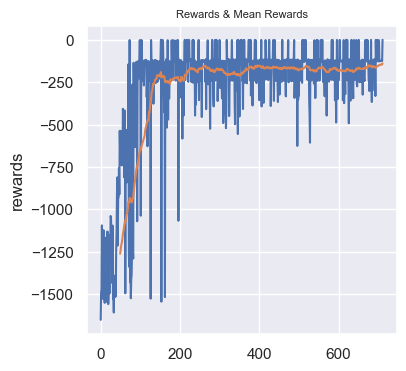

In [28]:
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

fig,ax=plt.subplots(1,1,sharex='col',sharey= False,figsize=(4,4))

sns.lineplot(df['rewards'], ax = ax)
sns.lineplot(df['mean_rewards'],ax = ax)
ax.set_title('Rewards & Mean Rewards',fontsize=8)

In [30]:
eval_agent = ddpg.Agent(lr_actor, lr_critic, 
              s_size=s_size, tau=0.001,
              batch_size=64, lyr1=128, lyr2=256, 
              a_size=a_size,
             )

eval_agent.load_model(model_file)

In [31]:
eval_env = gym.make(env_id,render_mode="human")
for epi in range(10):
    s, _ = eval_env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        act = eval_agent.choose_action(s)*2
        s_, r, _, done, _ = eval_env.step(act)
        steps += 1
        score += r
        
        #if score < -500:
        #    done = True
        
        #agent.memory.store(s, act, r, s_, done)
        #agent.learn()
        
        s = s_
    print(f'{score:.2f}')
eval_env.close()

-363.68
-121.18
-249.87
-1.33
-242.00
-1.07
-324.69
-119.23
-250.28
-116.20
